In [2]:
from flax import linen as nn

class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=120)(x)
        x = nn.sigmoid(x)
        x = nn.Dense(features=84)(x)
        x = nn.sigmoid(x)
        x = nn.Dense(features=10)(x)
        return x

In [3]:
import jax
import jax.numpy as jnp

net = MLP()
print(net.tabulate(jax.random.key(0), jnp.ones((1, 28, 28))))


                                  MLP Summary                                   
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs           ┃ outputs        ┃ params                ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ MLP    │ float32[1,28,28] │ float32[1,10]  │                       │
├─────────┼────────┼──────────────────┼────────────────┼───────────────────────┤
│ Dense_0 │ Dense  │ float32[1,784]   │ float32[1,120] │ bias: float32[120]    │
│         │        │                  │                │ kernel:               │
│         │        │                  │                │ float32[784,120]      │
│         │        │                  │                │                       │
│         │        │                  │                │ 94,200 (376.8 KB)     │
├─────────┼────────┼──────────────────┼────────────────┼───────────────────────┤
│ Dense_1 │ Dense  │ float3

In [4]:
from clu import metrics
from flax.training import train_state
from flax import struct
import optax

In [5]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

In [6]:
class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(module, optimizer, rng):
    params = module.init(rng, jnp.ones([1, 28, 28]))['params']
    train_state = TrainState.create(
        apply_fn=module.apply, params=params,
        tx=optimizer, metrics=Metrics.empty()
    )
    return train_state

In [7]:
@jax.jit
def train_step(state, X, y):
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, X)
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=y
        ).mean()
        return loss

    grads = jax.grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [8]:
@jax.jit
def compute_metrics(*, state, X, y):
    logits = state.apply_fn({'params': state.params}, X)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=y
    ).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=y, loss=loss
    )
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [9]:
import mnists
import numpy as np
from sklearn.model_selection import train_test_split

dataset = mnists.KMNIST()

X_train = dataset.train_images().astype(np.float32) / 255.0
y_train = dataset.train_labels().astype(np.int32)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.1, random_state=0,
)

X_test = dataset.test_images().astype(np.float32) / 255.0
y_test = dataset.test_labels().astype(np.int32)

In [10]:
def batch_data(X, y, batch_size):
    for i in range(0, len(y), batch_size):
        yield X[i:i+batch_size], y[i:i+batch_size]

In [39]:
def create_metrics_history():
    return {
        'epoch': 0,
        'train_loss': [],
        'train_accuracy': [],
        'valid_loss': [],
        'valid_accuracy': [],
        'test_loss': [],
        'test_accuracy': [],
        'best_valid_loss': np.inf,
        'best_epoch': 0,
    }

metrics_history = create_metrics_history()

# optimizer = optax.sgd(learning_rate=0.001, momentum=0.9, nesterov=True)
optimizer = optax.adam(learning_rate=0.001)
model = MLP()
state = best_state = create_train_state(model, optimizer, jax.random.key(0))

In [63]:
from copy import deepcopy
import time

def train_model(state, best_state, num_epochs, metrics_history,
                report_every, batch_size):
    metrics_history = deepcopy(metrics_history)
    
    start_epoch = metrics_history['epoch']

    for epoch in range(start_epoch, num_epochs):
        try:
            tic = time.time()
    
            for X_batch, y_batch in batch_data(X_train, y_train, batch_size):
                state = train_step(state, X_batch, y_batch)
                state = compute_metrics(state=state, X=X_batch, y=y_batch)
            
            for metric, value in state.metrics.compute().items():
                metrics_history[f'train_{metric}'].append(value)
    
            state = state.replace(metrics=state.metrics.empty())
    
            valid_state = compute_metrics(state=state, X=X_valid, y=y_valid)
            for metric, value in valid_state.metrics.compute().items():
                metrics_history[f'valid_{metric}'].append(value)
    
            if metrics_history['valid_loss'][-1] < metrics_history['best_valid_loss']:
                metrics_history['best_valid_loss'] = metrics_history['valid_loss'][-1]
                metrics_history['best_epoch'] = epoch + 1
                best_state = state
    
            metrics_history['epoch'] = epoch + 1
            
            if (epoch + 1) % report_every == 0:
                toc = time.time()
                print(
                    f"[{toc-tic:.3f}s] Epoch: {epoch+1: 5d}, "
                    f"[Train] loss: {metrics_history['train_loss'][-1]:.3f}, "
                    f"accuracy: {metrics_history['train_accuracy'][-1]:.3f}, "
                    f"[Valid] loss: {metrics_history['valid_loss'][-1]:.3f}, "
                    f"accuracy: {metrics_history['valid_accuracy'][-1]:.3f}"
                )
        except KeyboardInterrupt:
            break

    return state, best_state, metrics_history

state, best_state, metrics_history = train_model(
    state, best_state, num_epochs=300, report_every=10, 
    batch_size=6144, metrics_history=metrics_history
)

[0.790s] Epoch:    50, [Train] loss: 0.081, accuracy: 0.976, [Valid] loss: 0.111, accuracy: 0.969
[0.789s] Epoch:    60, [Train] loss: 0.069, accuracy: 0.980, [Valid] loss: 0.105, accuracy: 0.970
[0.788s] Epoch:    70, [Train] loss: 0.059, accuracy: 0.983, [Valid] loss: 0.096, accuracy: 0.973


In [61]:
def evaluate_on_test(state, best_state, metrics_history):
    def _evaluate(st, epoch):
        st = compute_metrics(state=st, X=X_test, y=y_test)

        print(f"[Test] Epoch: {epoch}", end=' ')
        for metric, value in st.metrics.compute().items():
            # metrics_history[f'test_{metric}'].append(value)
            print(f"{metric}: {value:.3f}", end=' ')
        print()

    _evaluate(best_state, metrics_history['best_epoch'])
    _evaluate(state, metrics_history['epoch'])
    return metrics_history

metrics_history = evaluate_on_test(state, best_state, metrics_history)

[Test] Epoch: 20 accuracy: 0.843 loss: 0.513 
[Test] Epoch: 20 accuracy: 0.847 loss: 0.502 


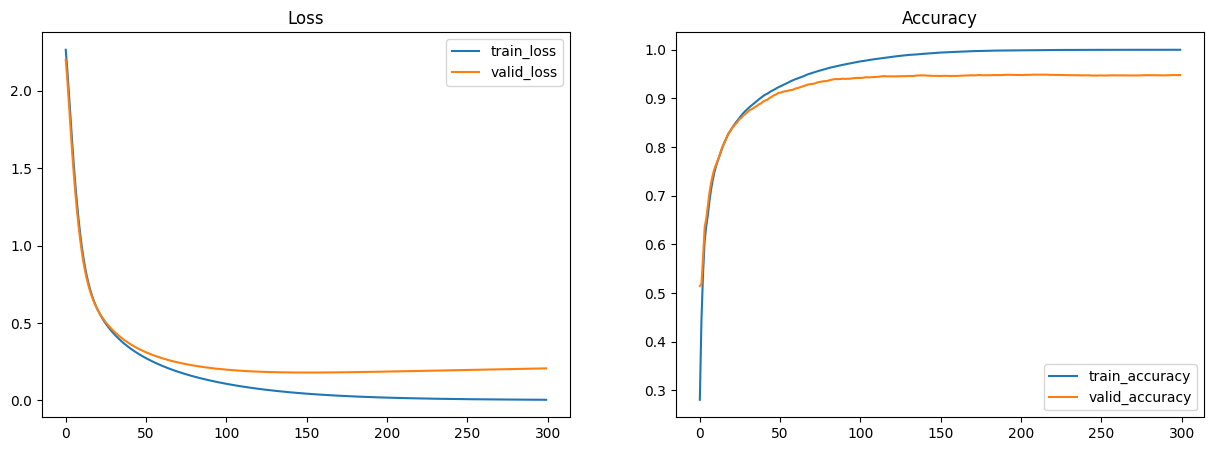

In [43]:
import matplotlib.pyplot as plt

def plot_metrics(metrics_history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title('Loss')
    ax2.set_title('Accuracy')
    for dataset in ('train','valid'):
        ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
        ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
    ax1.legend()
    ax2.legend()
    plt.show()

plot_metrics(metrics_history)

In [44]:
class LeNet(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = x[..., None]

        x = nn.Conv(features=6, kernel_size=(5, 5), padding=(2, 2))(x)
        x = nn.sigmoid(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = nn.Conv(features=16, kernel_size=(5, 5), padding=(0, 0))(x)
        x = nn.sigmoid(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = x.reshape((x.shape[0], -1))

        x = nn.Dense(features=120)(x)
        x = nn.sigmoid(x)

        x = nn.Dense(features=84)(x)
        x = nn.sigmoid(x)

        x = nn.Dense(features=10)(x)

        return x

In [45]:
lenet = LeNet()
print(lenet.tabulate(jax.random.key(0), jnp.ones((1, 28, 28))))


                                 LeNet Summary                                  
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs            ┃ outputs           ┃ params            ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│         │ LeNet  │ float32[1,28,28]  │ float32[1,10]     │                   │
├─────────┼────────┼───────────────────┼───────────────────┼───────────────────┤
│ Conv_0  │ Conv   │ float32[1,28,28,… │ float32[1,28,28,… │ bias: float32[6]  │
│         │        │                   │                   │ kernel:           │
│         │        │                   │                   │ float32[5,5,1,6]  │
│         │        │                   │                   │                   │
│         │        │                   │                   │ 156 (624 B)       │
├─────────┼────────┼───────────────────┼───────────────────┼───────────────────┤
│ Conv_1  │ Conv   │ float3

In [64]:
metrics_history = create_metrics_history()

# optimizer = optax.sgd(learning_rate=0.0001)
optimizer = optax.adam(learning_rate=0.001)
model = LeNet()
state = best_state = create_train_state(model, optimizer, jax.random.key(0))

In [66]:
state, best_state, metrics_history = train_model(
    state, best_state, num_epochs=810, report_every=10, 
    batch_size=8192, metrics_history=metrics_history
)

[0.728s] Epoch:    50, [Train] loss: 0.508, accuracy: 0.850, [Valid] loss: 0.507, accuracy: 0.845


In [67]:
metrics_history = evaluate_on_test(state, best_state, metrics_history)

[Test] Epoch: 53 accuracy: 0.730 loss: 0.840 
[Test] Epoch: 53 accuracy: 0.735 loss: 0.828 


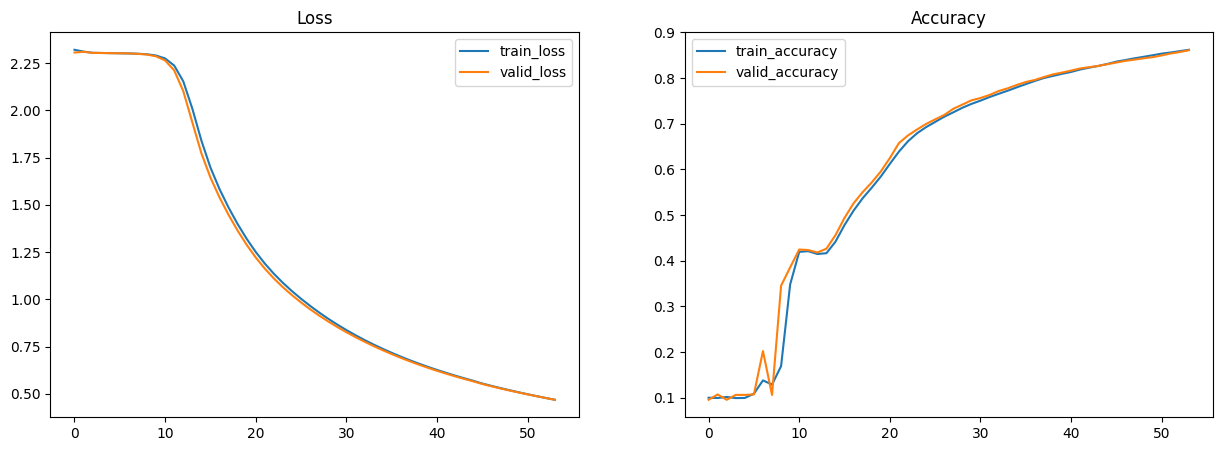

In [68]:
plot_metrics(metrics_history)

In [69]:
class LeNetWithReLUAndMaxPool(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = x[..., None]

        x = nn.Conv(features=6, kernel_size=(5, 5), padding=(2, 2))(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = nn.Conv(features=16, kernel_size=(5, 5), padding=(0, 0))(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = x.reshape((x.shape[0], -1))

        x = nn.Dense(features=120)(x)
        x = nn.relu(x)

        x = nn.Dense(features=84)(x)
        x = nn.relu(x)

        x = nn.Dense(features=10)(x)

        return x

In [70]:
metrics_history = create_metrics_history()

# optimizer = optax.sgd(learning_rate=0.0001)
optimizer = optax.adam(learning_rate=0.001)
model = LeNetWithReLUAndMaxPool()
state = best_state = create_train_state(model, optimizer, jax.random.key(0))

In [71]:
state, best_state, metrics_history = train_model(
    state, best_state, num_epochs=1000, report_every=10, 
    batch_size=4096, metrics_history=metrics_history
)
evaluate_on_test(state, best_state, metrics_history);

[0.793s] Epoch:    10, [Train] loss: 0.308, accuracy: 0.906, [Valid] loss: 0.307, accuracy: 0.905
[0.791s] Epoch:    20, [Train] loss: 0.164, accuracy: 0.950, [Valid] loss: 0.183, accuracy: 0.948
[0.790s] Epoch:    30, [Train] loss: 0.112, accuracy: 0.967, [Valid] loss: 0.142, accuracy: 0.957
[Test] Epoch: 31 accuracy: 0.894 loss: 0.370 
[Test] Epoch: 31 accuracy: 0.895 loss: 0.366 


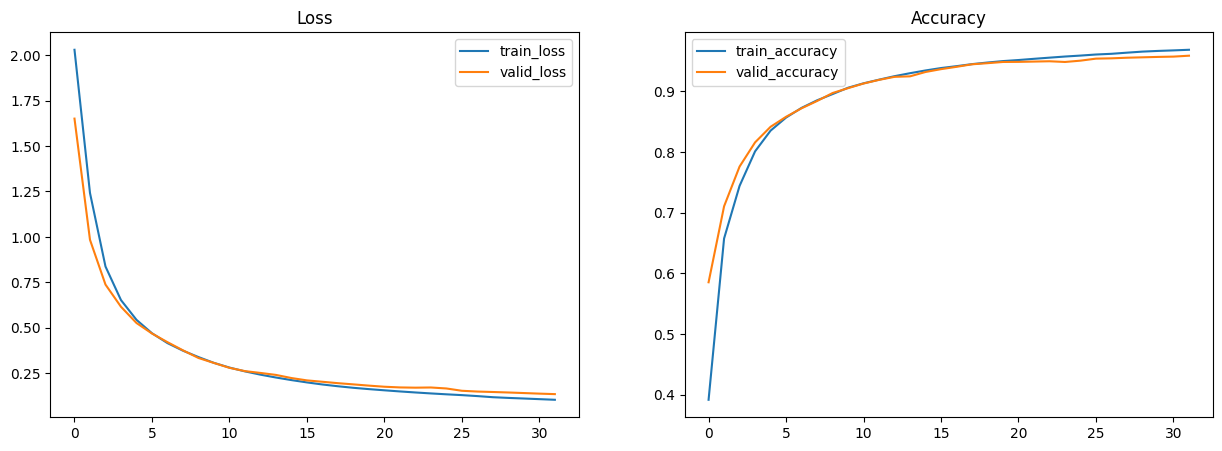

In [72]:
plot_metrics(metrics_history)

In [11]:
class CNNDropout(nn.Module):
    @nn.compact
    def __call__(self, x, training: bool):
        x = x[..., None]
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Dropout(rate=0.5, deterministic=not training)(x)
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Dropout(rate=0.5, deterministic=not training)(x)
        x = x.reshape((x.shape[0], -1))
        x = nn.Dropout(rate=0.5, deterministic=not training)(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=0.5, deterministic=not training)(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=0.5, deterministic=not training)(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=0.5, deterministic=not training)(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=0.5, deterministic=not training)(x)
        x = nn.Dense(features=10)(x)
        return x

cnnd = CNNDropout()

In [12]:
print(cnnd.tabulate(jax.random.key(0), jnp.ones((1, 28, 28)), training=False))


                               CNNDropout Summary                               
┏━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ path      ┃ module     ┃ inputs          ┃ outputs         ┃ params          ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│           │ CNNDropout │ -               │ float32[1,10]   │                 │
│           │            │ float32[1,28,2… │                 │                 │
│           │            │ - training:     │                 │                 │
│           │            │ False           │                 │                 │
├───────────┼────────────┼─────────────────┼─────────────────┼─────────────────┤
│ Conv_0    │ Conv       │ float32[1,28,2… │ float32[1,28,2… │ bias:           │
│           │            │                 │                 │ float32[32]     │
│           │            │                 │                 │ kernel:         │
│           │            │ 

In [13]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    key: jax.Array

def create_train_state(module, optimizer, rng, dropout_key):
    params = module.init(rng, jnp.ones([1, 28, 28]), training=False)['params']
    train_state = TrainState.create(
        apply_fn=module.apply, params=params, tx=optimizer, metrics=Metrics.empty(), key=dropout_key
    )
    return train_state

In [14]:
@jax.jit
def train_step(state, X, y, dropout_key):
    dropout_train_key = jax.random.fold_in(key=dropout_key, data=state.step)

    def loss_fn(params):
        logits = state.apply_fn({'params': params}, X, training=True, rngs={'dropout': dropout_train_key})
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=y
        ).mean()
        return loss

    grads = jax.grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [15]:
@jax.jit
def compute_metrics(*, state, X, y):
    logits = state.apply_fn({'params': state.params}, X, training=False)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=y
    ).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=y, loss=loss
    )
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [18]:
num_epochs = 1000
report_every = 5

metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

# optimizer = optax.sgd(learning_rate=0.001, momentum=0.9, nesterov=True)
optimizer = optax.adam(learning_rate=0.001)
state = create_train_state(cnnd, optimizer, jax.random.key(0), jax.random.key(1))

for epoch in range(num_epochs):
    for X_batch, y_batch in zip(X_train, y_train):
        state = train_step(state, X_batch, y_batch, jax.random.key(2))
        state = compute_metrics(state=state, X=X_batch, y=y_batch)

    for metric, value in state.metrics.compute().items():
        metrics_history[f'train_{metric}'].append(value)

    state = state.replace(metrics=state.metrics.empty())

    test_state = state
    for X_batch, y_batch in zip(X_test, y_test):
        test_state = compute_metrics(state=test_state, X=X_batch, y=y_batch)

    for metric, value in test_state.metrics.compute().items():
        metrics_history[f'test_{metric}'].append(value)

    if (epoch + 1) % report_every == 0:
        print(f"Epoch: {epoch+1: 3d}, "
            f"[Train] loss: {metrics_history['train_loss'][-1]:.3f}, "
            f"accuracy: {metrics_history['train_accuracy'][-1]:.3f}, "
            f"[Test] loss: {metrics_history['test_loss'][-1]:.3f}, "
            f"accuracy: {metrics_history['test_accuracy'][-1]:.3f}")

Epoch:   5, [Train] loss: 0.732, accuracy: 0.708, [Test] loss: 0.740, accuracy: 0.698
Epoch:  10, [Train] loss: 0.601, accuracy: 0.744, [Test] loss: 0.615, accuracy: 0.736
Epoch:  15, [Train] loss: 0.630, accuracy: 0.737, [Test] loss: 0.652, accuracy: 0.733
Epoch:  20, [Train] loss: 0.627, accuracy: 0.741, [Test] loss: 0.643, accuracy: 0.767
Epoch:  25, [Train] loss: 0.710, accuracy: 0.727, [Test] loss: 0.698, accuracy: 0.743
Epoch:  30, [Train] loss: 0.719, accuracy: 0.720, [Test] loss: 0.720, accuracy: 0.713
Epoch:  35, [Train] loss: 0.709, accuracy: 0.720, [Test] loss: 0.918, accuracy: 0.704
Epoch:  40, [Train] loss: 0.967, accuracy: 0.658, [Test] loss: 1.128, accuracy: 0.644
Epoch:  45, [Train] loss: 1.483, accuracy: 0.366, [Test] loss: 1.533, accuracy: 0.337
Epoch:  50, [Train] loss: 2.148, accuracy: 0.149, [Test] loss: 2.114, accuracy: 0.173


KeyboardInterrupt: 

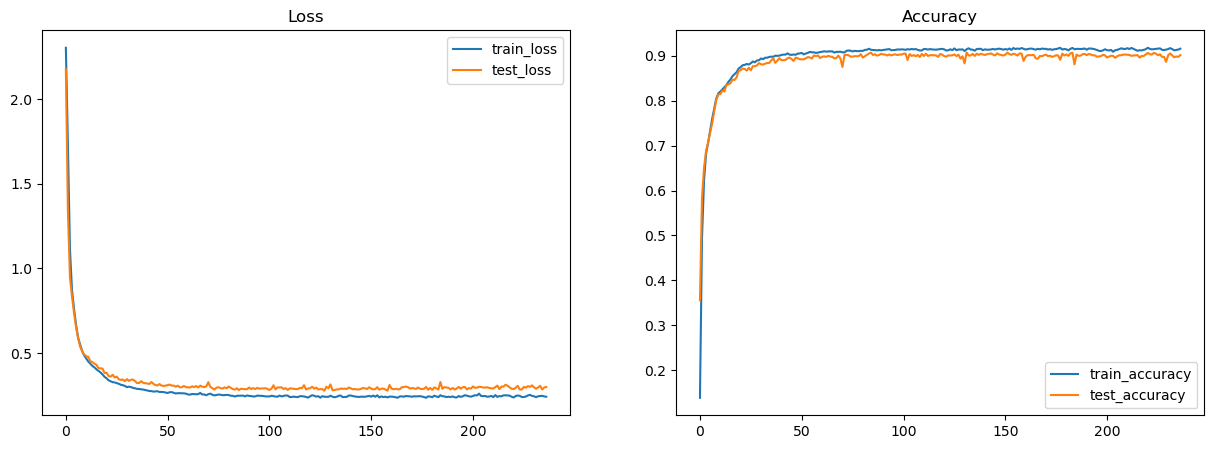

<Figure size 640x480 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
    ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [39]:
class ResBlock(nn.Module):
    @nn.compact
    def __call__(self, x):
        x1 = x
        x = nn.Dense(features=1024)(x)
        x = nn.relu(x)
        return x + x1

class Resnet(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = x[..., None]

        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = nn.Conv(features=128, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=1024)(x)

        x = ResBlock()(x)
        x = ResBlock()(x)
        x = ResBlock()(x)
        x = ResBlock()(x)
        x = ResBlock()(x)
        x = ResBlock()(x)

        x = nn.Dense(features=10)(x)
        return x

resnet = Resnet()

In [40]:
print(resnet.tabulate(jax.random.key(0), jnp.ones((1, 28, 28))))


                                 Resnet Summary                                 
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path           ┃ module   ┃ inputs         ┃ outputs        ┃ params         ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│                │ Resnet   │ float32[1,28,… │ float32[1,10]  │                │
├────────────────┼──────────┼────────────────┼────────────────┼────────────────┤
│ Conv_0         │ Conv     │ float32[1,28,… │ float32[1,28,… │ bias:          │
│                │          │                │                │ float32[32]    │
│                │          │                │                │ kernel:        │
│                │          │                │                │ float32[3,3,1… │
│                │          │                │                │                │
│                │          │                │                │ 320 (1.3 KB)   │
├────────────────┼─────────

In [41]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

In [42]:
class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(module, optimizer, rng):
    params = module.init(rng, jnp.ones([1, 28, 28]))['params']
    train_state = TrainState.create(
        apply_fn=module.apply, params=params, tx=optimizer, metrics=Metrics.empty()
    )
    return train_state

In [43]:
@jax.jit
def train_step(state, X, y):
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, X)
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=y
        ).mean()
        return loss

    grads = jax.grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [44]:
@jax.jit
def compute_metrics(*, state, X, y):
    logits = state.apply_fn({'params': state.params}, X)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=y
    ).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=y, loss=loss
    )
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [48]:
num_epochs = 1000
report_every = 1

metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

optimizer = optax.sgd(learning_rate=0.0001, momentum=0.9, nesterov=True)
# optimizer = optax.adam(learning_rate=0.001)#, momentum=0.9, nesterov=True)
state = create_train_state(resnet, optimizer, jax.random.key(0))

for epoch in range(num_epochs):
    for X_batch, y_batch in zip(X_train, y_train):
        state = train_step(state, X_batch, y_batch)
        state = compute_metrics(state=state, X=X_batch, y=y_batch)

    for metric, value in state.metrics.compute().items():
        metrics_history[f'train_{metric}'].append(value)

    state = state.replace(metrics=state.metrics.empty())

    test_state = state
    for X_batch, y_batch in zip(X_test, y_test):
        test_state = compute_metrics(state=test_state, X=X_batch, y=y_batch)

    for metric, value in test_state.metrics.compute().items():
        metrics_history[f'test_{metric}'].append(value)

    if (epoch + 1) % report_every == 0:
        print(f"Epoch: {epoch+1: 3d}, "
            f"[Train] loss: {metrics_history['train_loss'][-1]:.3f}, "
            f"accuracy: {metrics_history['train_accuracy'][-1]:.3f}, "
            f"[Test] loss: {metrics_history['test_loss'][-1]:.3f}, "
            f"accuracy: {metrics_history['test_accuracy'][-1]:.3f}")

Epoch:   1, [Train] loss: 5.248, accuracy: 0.278, [Test] loss: 1.864, accuracy: 0.391
Epoch:   2, [Train] loss: 1.765, accuracy: 0.429, [Test] loss: 1.716, accuracy: 0.458
Epoch:   3, [Train] loss: 1.637, accuracy: 0.481, [Test] loss: 1.597, accuracy: 0.499
Epoch:   4, [Train] loss: 1.523, accuracy: 0.516, [Test] loss: 1.481, accuracy: 0.530
Epoch:   5, [Train] loss: 1.412, accuracy: 0.550, [Test] loss: 1.369, accuracy: 0.565
Epoch:   6, [Train] loss: 1.303, accuracy: 0.615, [Test] loss: 1.256, accuracy: 0.645
Epoch:   7, [Train] loss: 1.181, accuracy: 0.670, [Test] loss: 1.114, accuracy: 0.686
Epoch:   8, [Train] loss: 1.019, accuracy: 0.707, [Test] loss: 0.938, accuracy: 0.725
Epoch:   9, [Train] loss: 0.836, accuracy: 0.749, [Test] loss: 0.778, accuracy: 0.757
Epoch:  10, [Train] loss: 0.692, accuracy: 0.781, [Test] loss: 0.664, accuracy: 0.786
Epoch:  11, [Train] loss: 0.589, accuracy: 0.804, [Test] loss: 0.584, accuracy: 0.803
Epoch:  12, [Train] loss: 0.522, accuracy: 0.820, [Tes

KeyboardInterrupt: 